# Bayesian Modeling of COVID-19

In [1]:
#hide
from pathlib import Path

loadpy = Path('load_covid_data.py')
if not loadpy.exists():
    ! wget https://raw.githubusercontent.com/github/covid19-dashboard/master/_notebooks/load_covid_data.py

In [4]:
#hide
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm

import load_covid_data

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

## Set this to true to see legacy charts
debug=False

## Data

In [5]:
#hide

df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
# We only have data for China after they already had a significant number of cases.
# They also are not well modeled by the exponential, so we drop them here for simplicity.
df = df.loc[lambda x: x.country != 'China (total)']

countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]

annotate_kwargs = dict(
    s='Based on COVID Data Repository by Johns Hopkins CSSE ({})\nBy Thomas Wiecki'.format(df.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.01), xycoords='figure fraction', fontsize=10)

## Bayesian Workflow

1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence
6. Run posterior predictive check
7. Potentially improve model

## 1. Plot the data

In [7]:
country = 'US'
df_country = df.loc[lambda x: (x.country == country)].iloc[:50]

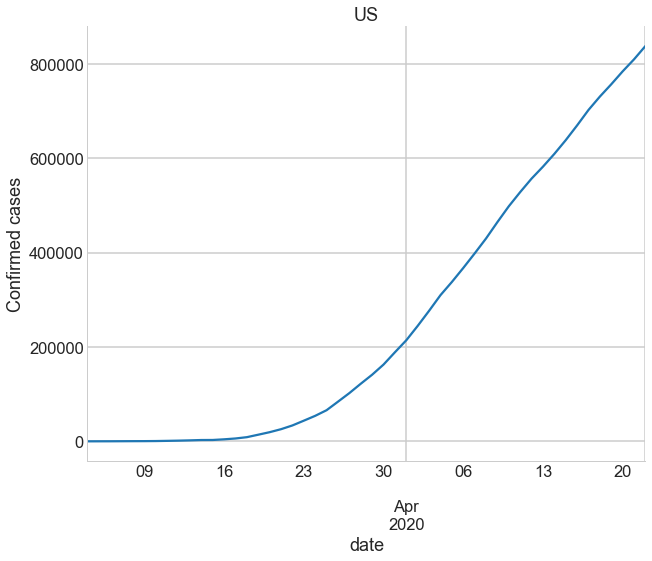

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()

## 2. Build model

In [56]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values
    
with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=0, sigma=25)
    
    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.3)
    
    # Exponential regression
    growth = a * (1 + b) ** t
    
    # Error term    
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    pm.Normal('US', 
              mu=growth, 
              sigma=eps,
              observed=confirmed)

## 3. Run prior predictive check

What?

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

The process works as follows:

1. Pick a point from the prior $\theta_i$
2. Generate data set $x_i \sim f(\theta_i)$ where $f$ is our likelihood function (e.g. normal).
3. Rinse and repeat $n$ times.

In [57]:
with model:
    prior_pred = pm.sample_prior_predictive()

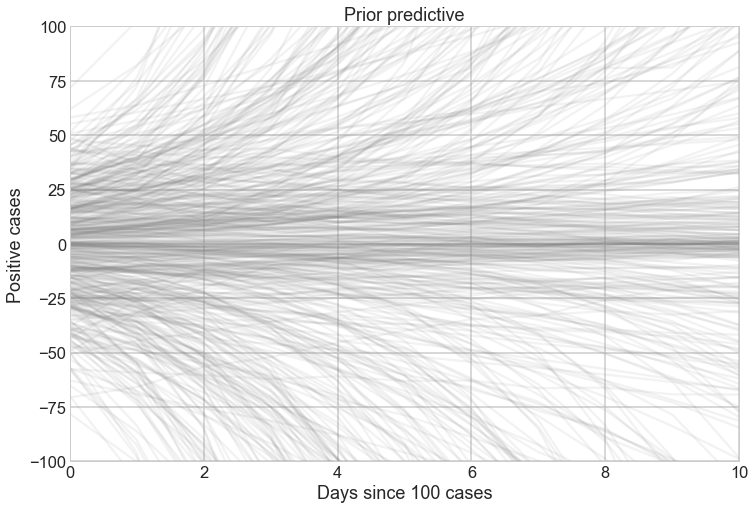

In [58]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 100),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

Problems:

1. Cases can't be negative
2. Cases can not start at 0, but somewhere around 100.
3. Positive cases can not go down

In [81]:
t = df_country.days_since_100.values
confirmed = df_country.confirmed.values
    
with pm.Model() as model:
    # Intercept
    a = pm.Normal('a', mu=100, sigma=25)
    
    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)
    
    # Exponential regression
    growth = a * (1 + b) ** t
    
    # Error term    
    eps = pm.HalfNormal('eps')
    
    # Likelihood
    pm.Lognormal('US', 
                 mu=pm.math.log(growth), 
                 sigma=eps,
                 observed=confirmed)

In [82]:
with model:
    prior_pred = pm.sample_prior_predictive()

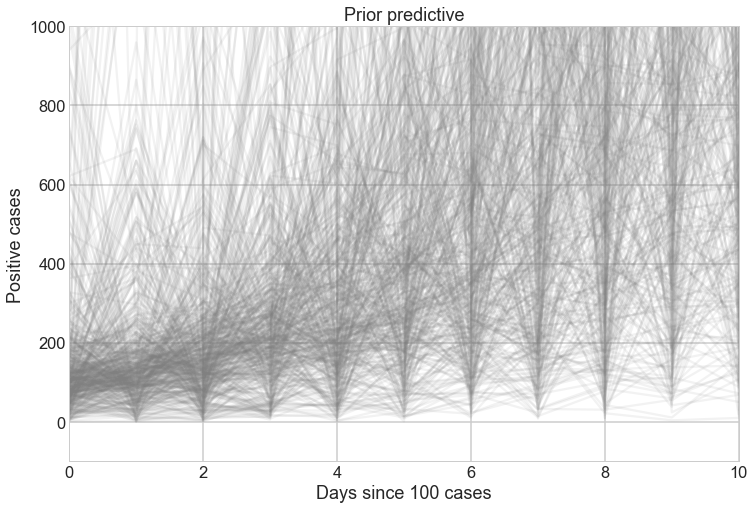

In [83]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred['US'].T, color="0.5", alpha=.1);
ax.set(ylim=(-100, 1000),
       xlim=(0, 10),
       title="Prior predictive", 
       xlabel="Days since 100 cases",
       ylabel="Positive cases");

## 4. Fit model (hit the Inference Button)

In [67]:
with model:
    # Inference button (TM)
    trace = pm.sample(cores=4, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


## 5. Assess convergence

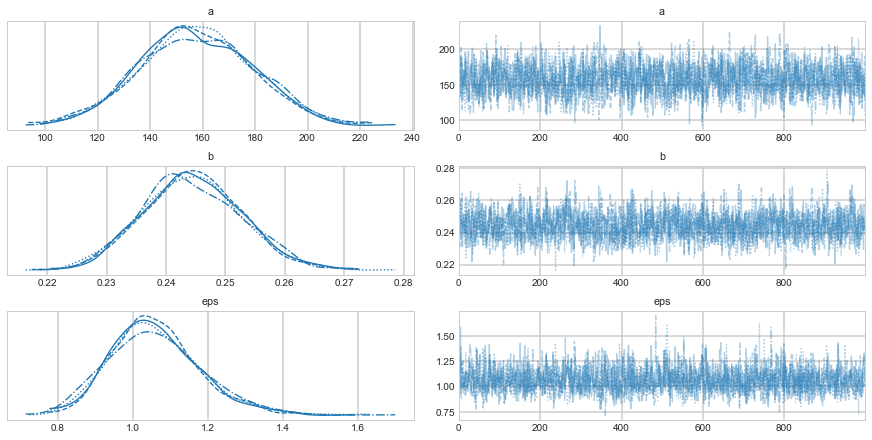

In [84]:
with model:
    pm.traceplot(trace);

In [86]:
with model:
    print(pm.rhat(trace))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 1.003
    b        float64 1.001
    eps      float64 1.002


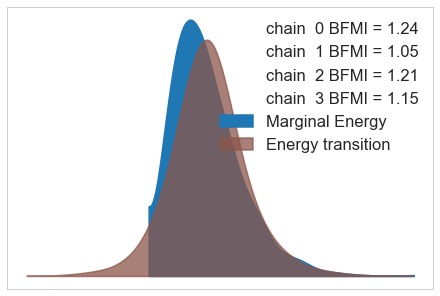

In [70]:
pm.plot_energy(trace);

## 6. Run posterior predictive check

In [71]:
with model:  
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace)

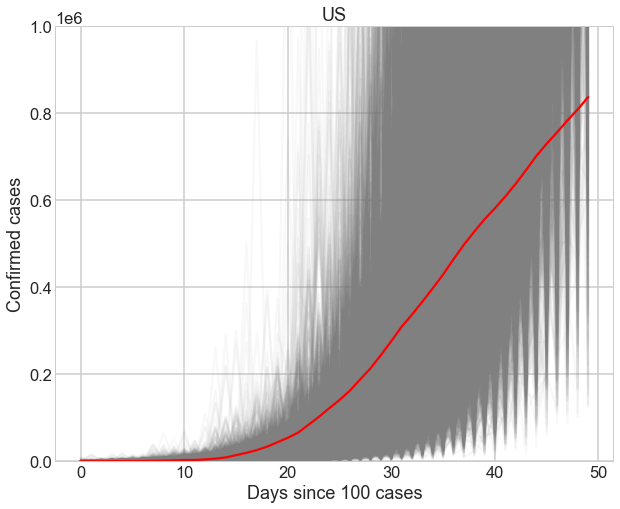

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['US'].T, color='0.5', alpha=.05);
ax.plot(confirmed, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases', 
       ylim=(0, 1_000_000), title=country);

## 7. Improve model

### Hierarchical exponential growth model

<img src="https://media-exp1.licdn.com/dms/image/C5612AQES5GhZtk9p3A/article-cover_image-shrink_720_1280/0?e=1599696000&v=beta&t=8ra5o6qD9FaTXSzjEcWdcAaxMuQNy-fiOYR9DyZcsKE"/>

In [ ]:
with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_countries)
    
    eps = pm.HalfNormal('eps')
    
    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df.loc[lambda x: (x.country == country)]
        
        growth = a_ind[i] * b_ind[i] ** df_country.days_since_100
        
        # Likelihood
        pm.Lognormal(
            country_name, 
            mu=pm.math.log(growth),
            sigma=eps,
            observed=df_country.confirmed)

## Logistic model

<img src="https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/924/2015/11/25202016/CNX_Precalc_Figure_04_07_0062.jpg"/>

In [94]:
x = df_country.days_since_100.values
cases = df_country.confirmed.values
    
with pm.Model() as logistic_model:
    # Define priors
    intercept = pm.Normal('a', mu=100, sigma=30)
    b = pm.Normal('b', .3, .1)
    carrying_capacity = pm.Uniform('carrying_capacity', 
                                   lower=1_000, 
                                   upper=10_000_000)

    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * x))

    eps = pm.HalfNormal('eps', 1)
    
    # Likelihood
    pm.Lognormal('US', pm.math.log(growth), eps, observed=cases)

In [95]:
with logistic_model:
    # Inference
    trace = pm.sample(tune=1000, chains=4, cores=4, target_accept=.9)

    # Sample posterior predcitive
    post_pred = pm.sample_posterior_predictive(trace, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, carrying_capacity, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
/Users/twiecki/working/projects/pymc/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


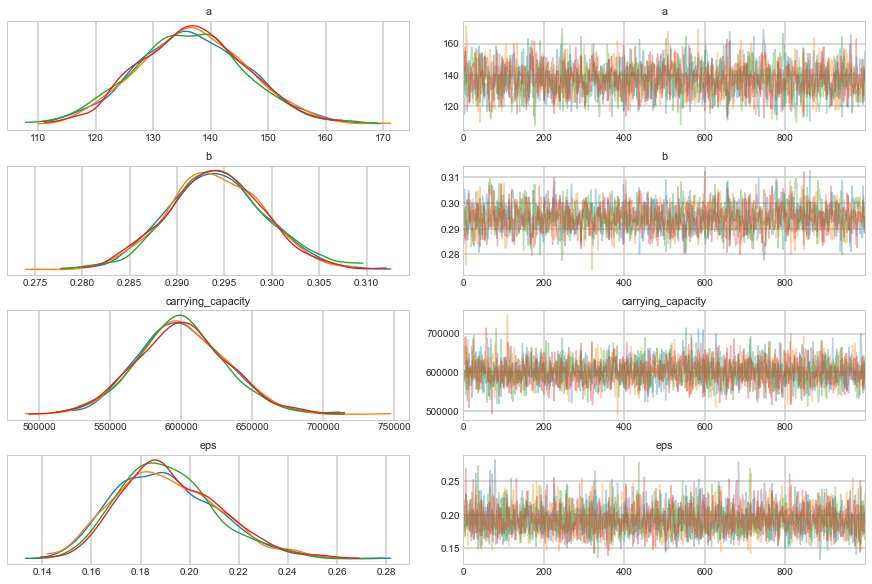

In [96]:
with logistic_model:
    pm.plot_trace(trace)

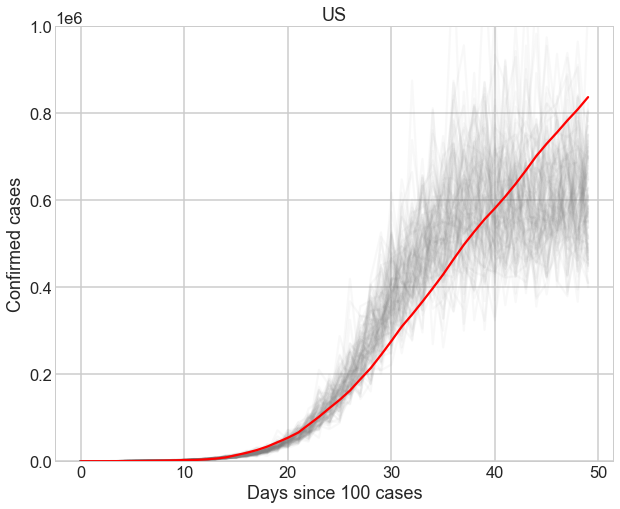

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(post_pred['US'].T, color='0.5', alpha=.05);
ax.plot(confirmed, color='r')
ax.set(xlabel='Days since 100 cases', ylabel='Confirmed cases', 
       ylim=(0, 1_000_000), title=country);

## About This Analysis

This analysis was done by [Thomas Wiecki](https://twitter.com/twiecki). Interactive visualizations were created by [Hamel Husain](https://twitter.com/HamelHusain).

The model that we are building assumes exponential growth. This is definitely wrong because growth would just continue uninterrupted into the future. However, in the early phase of an epidemic it's a reasonable assumption.[^1]

We assume a [negative binomial](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial) likelihood as we are dealing with count data. A Poisson could also be used but the negative binomial allows us to also model the variance separately to give more flexibility.

The model is also hierarchical, pooling information from individual countries.


[^1]:  This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19). This code is provided under the [BSD-3 License](https://github.com/twiecki/covid19/blob/master/LICENSE). Link to [original notebook](https://github.com/twiecki/covid19/blob/master/covid19_growth_bayes.ipynb).